In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow.compat.v1 as tf1 
from tensorflow.python.framework import ops

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
import os

In [5]:
from tensorflow.keras.models import load_model

In [6]:
os.chdir('E:/')

In [7]:
resnet = load_model('resnetresult.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
img_size = (227, 227)
mapping = {0:'asd', 1:'avsd', 2:'normal', 3:'vsd'}
last_conv_layer_name = "add_11" 

In [23]:
img_path = "aug_40_752-removebg-preview.png" #avsd
img_path1 = "SYAKILA__ASD_KESESUAIAN__SUB_118-removebg-preview.png" #asd
img_path2 = "ATTARAZKA_ALGHIFARI_4CH_11-removebg-preview.png" #normal
img_path3 = "ERRA_TUNGGA_MAHARDIKA__VSD__5CH_19-removebg-preview.png" #vsd

In [10]:
def load_image(path, preprocess=True):
    img_temp = cv2.imread(path)
    img_temp = cv2.resize(img_temp, img_size)
    img_temp = img_temp.astype('float32') / 255.0 
    if preprocess:
        img_temp= np.array(img_temp)
        img_temp = np.expand_dims(img_temp, axis=0)
    return img_temp

def deprocess_image(x):
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255 #to convert into RGB
    if K.image_data_format() == 'th': #to convert type 'th' to type 'tf'
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
"""Function returning modified model.    
Changes gradient function for all ReLu activations
according to Guided Backpropagation.
"""
def build_guided_model():
    if "GuidedBackProp" not in ops._gradient_registry._registry: #avoid over-write
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf1.cast(grad > 0., dtype) * \
                   tf1.cast(op.inputs[0] > 0., dtype)

    g = tf1.get_default_graph()       #guidedbackdrop in another copy
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = load_model('resnetresult.h5')
    return new_model

#Guided Backpropagation method
def guided_backprop(input_model, images, layer_name): 
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [12]:
#GradCAM method
def grad_cam(input_model, image, cls, layer_name): 
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_size, cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [13]:
def guided_gradcam_fn(model, guided_model, img_path, layer_name, cls=-1, visualize=True, save=True):
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)
    top = np.argmax(predictions)
    print('Model prediction: '+ mapping[top])
    print()
    print('Probabilities:')
    for i in range(4):
      print('\t{}. {}\t{:.3f}'.format(i, mapping[i], predictions[0,i]))
  
    if cls == -1:
        cls = np.argmax(predictions)
    print()
    print("Explanation for '{}':".format(mapping[cls]))
    print()
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam
     

In [14]:
guided_model = build_guided_model()

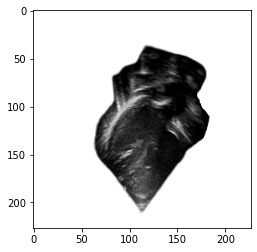

In [15]:
plt.imshow(load_image(img_path, preprocess=False))

C:\Users\bayui\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model prediction: avsd

Probabilities:
	0. asd	0.000
	1. avsd	1.000
	2. normal	0.000
	3. vsd	0.000

Explanation for 'avsd':



<ipython-input-12-73f42edd49a7>:16: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()
C:\Users\bayui\Anaconda3\lib\site-packages\matplotlib\image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\bayui\Anaconda3\lib\site-packages\matplotlib\image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\bayui\Anaconda3\lib\site-packages\matplotlib\image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\bayui\Anaconda3\lib\site-packages\matplotlib\colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


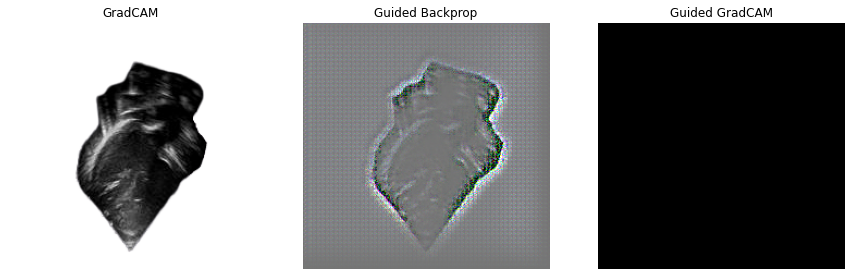

In [16]:
gradcam, gb, guided_gradcam = guided_gradcam_fn(resnet, guided_model, img_path, layer_name=last_conv_layer_name, 
                                               cls=-1, visualize=True, save=True)
     

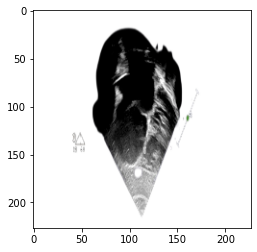

In [18]:
plt.imshow(load_image(img_path1, preprocess=False))

Model prediction: avsd

Probabilities:
	0. asd	0.000
	1. avsd	1.000
	2. normal	0.000
	3. vsd	0.000

Explanation for 'avsd':



<ipython-input-12-73f42edd49a7>:16: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


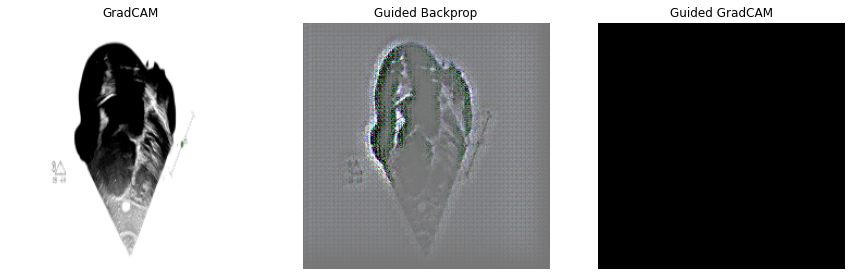

In [19]:
gradcam, gb, guided_gradcam = guided_gradcam_fn(resnet, guided_model, img_path1, layer_name=last_conv_layer_name, 
                                               cls=-1, visualize=True, save=True)
     

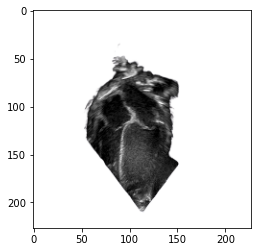

In [21]:
plt.imshow(load_image(img_path2, preprocess=False))

Model prediction: avsd

Probabilities:
	0. asd	0.000
	1. avsd	1.000
	2. normal	0.000
	3. vsd	0.000

Explanation for 'avsd':



<ipython-input-12-73f42edd49a7>:16: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


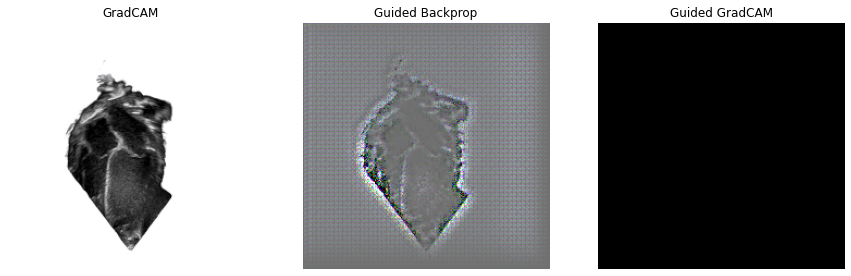

In [22]:
gradcam, gb, guided_gradcam = guided_gradcam_fn(resnet, guided_model, img_path2, layer_name=last_conv_layer_name, 
                                               cls=-1, visualize=True, save=True)
     

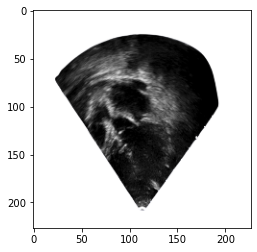

In [24]:
plt.imshow(load_image(img_path3, preprocess=False))

Model prediction: avsd

Probabilities:
	0. asd	0.000
	1. avsd	1.000
	2. normal	0.000
	3. vsd	0.000

Explanation for 'avsd':



<ipython-input-12-73f42edd49a7>:16: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


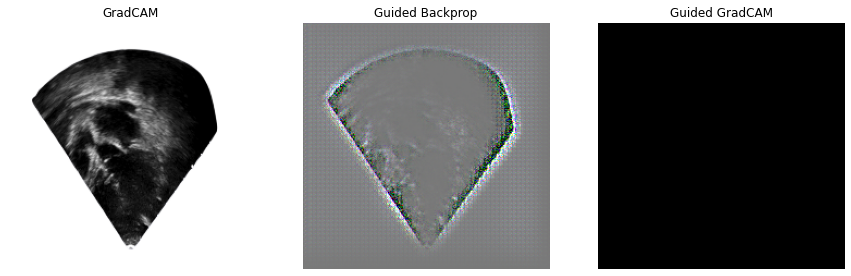

In [25]:
gradcam, gb, guided_gradcam = guided_gradcam_fn(resnet, guided_model, img_path3, layer_name=last_conv_layer_name, 
                                               cls=-1, visualize=True, save=True)
     